<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>

# 5a. Pre-Trained Models

Though it is often necessary to have a large, well annotated dataset to solve a deep learning challenge, there are many  freely available pre-trained models that we can use right out of the box. As you decide to take on your own deep learning project, it is a great idea to start by looking for existing models online that can help you achieve your goal. A great place to explore available models is [NGC](https://ngc.nvidia.com/catalog/models). There are also many models hosted on GitHub that you can find through searching on Google. 

## 5a.1 Objectives

* Use TorchVision to load a very well-trained pretrained model
* Preprocess our own images to work with the pretrained model
* Use the pretrained model to perform accurate inference on your own images

In [1]:
import torch
import torchvision.transforms.v2 as transforms
import torchvision.io as tv_io

import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

## 5a.2 An Automated Doggy Door

In this section, we will be creating a doggy door that only lets dogs (and not other animals) in and out. We can keep our cats inside, and other animals outside where they belong. Using the techniques covered so far, we would need a very large dataset with pictures of many dogs, as well as other animals. Luckily, there is a readily available model that has been trained on a massive dataset, including lots of animals. 

The [ImageNet challenge](https://en.wikipedia.org/wiki/ImageNet#History_of_the_ImageNet_challenge) has produced many state-of-the-art models that can be used for image classification. They are trained on millions of images, and can accurately classify images into 1000 different categories. Many of those categories are animals, including breeds of dogs and cats. This is a perfect model for our doggy door.

## 5a.3 Loading the Model

We will start by downloading the model. Trained ImageNet models are available to download directly within the TorchVision library. We can see the available models and their details [here](https://pytorch.org/vision/stable/models.html). Any of these models would work for our exercise. We will pick a commonly used one called [VGG16](https://pytorch.org/vision/stable/models/vgg.html) and use the [default weights](https://pytorch.org/vision/stable/models/generated/torchvision.models.vgg19.html#torchvision.models.VGG19_Weights).

In [2]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

# load the VGG16 network *pre-trained* on the ImageNet dataset
weights = VGG16_Weights.DEFAULT
model = vgg16(weights=weights)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\grsim/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100.0%


Now that it is loaded, let us look at the model. It looks a lot like our convolutional model from the sign language exercise.

In [3]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 5a.3.1 Input dimensions

As with our earlier exercises, our images should match the input dimensions that the model expects. Because PyTorch models are dynamically built, the model itself does not know what its input shape should be. Thankfully, the pretrained `weights` come with their own transforms.

In [4]:
pre_trans = weights.transforms()
pre_trans

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

This is eqiuvalent to the following:

```Python
IMG_WIDTH, IMG_HEIGHT = (224, 224)

pre_trans = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True), # Converts [0, 255] to [0, 1]
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    transforms.CenterCrop(224)
])
```

One new Transform here is [Normalize](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html) which will recolor an image based on a provided [mean](https://en.wikipedia.org/wiki/Mean) and [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation). The other new Transform is [CenterCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.CenterCrop.html#torchvision.transforms.v2.CenterCrop), which removes the edges of the image. We can apply these transforms to any image tensor we'd like to use with the VGG16 model.

### 5a.3.2 Output dimensions

We can also see that the model will return a prediction of shape 1000. Remember that in our first exercise the output shape of our model was 10, corresponding to the 10 different digits. In our second exercise we had a shape of 24, corresponding to the 24 letters of the sign language alphabet that could be captured in a still image. Here, we have 1000 possible categories that the image will be placed in. Though the full ImageNet dataset has over 20,000 categories, the competition and resulting pre-trained models just use a subset of 1000 of these categories. We can take a look at all of these [possible categories here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

Many of the categories are animals, including many types of dogs and cats. The dogs are categories 151 through 268. The cats are categories 281 through 285. We will be able to use these categories to tell our doggy door what type of animal is at our door, and whether we should let them in or not.

## 5a.4 Loading an Image
We will start by loading in an image and displaying it, as we have done in previous exercises.

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

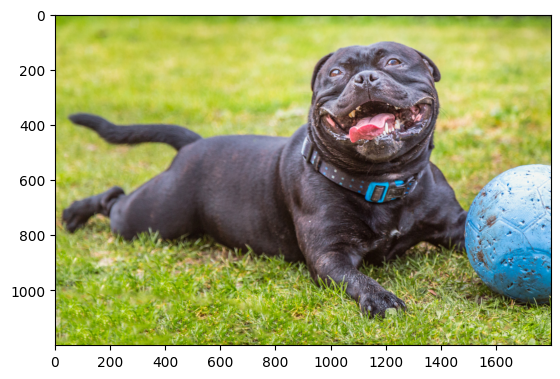

In [6]:
show_image("../Data/doggy_door_images/happy_dog.jpg")

### 5a.4.1 Preprocessing the Image

Next, we will preprocess the image so that it is ready to be sent into the model. This is just like what we did in our last exercise when we predicted on the sign language images. Remember that in this case, the final shape of the image should be (1, 3, 224, 224). We will use the Transforms provided by `weights` to so this.

In [7]:
def load_and_process_image(file_path):
    # Print image's original shape, for reference
    print('Original image shape: ', mpimg.imread(file_path).shape)
    
    image = tv_io.read_image(file_path).to(device)
    image = pre_trans(image)  # weights.transforms()
    image = image.unsqueeze(0)  # Turn into a batch
    return image

Let's practice on our happy dog photo and see if it worked:

In [9]:
processed_image = load_and_process_image("../Data/doggy_door_images/happy_dog.jpg")
print("Processed image shape: ", processed_image.shape)

Original image shape:  (1200, 1800, 3)
Processed image shape:  torch.Size([1, 3, 224, 224])


The shape is correct, but how does it look? Let's print an image to verify:

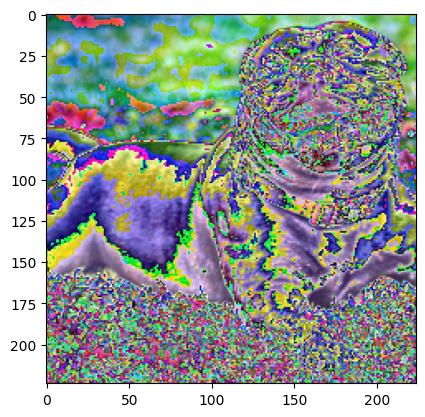

In [10]:
import torchvision.transforms.functional as F

plot_image = F.to_pil_image(torch.squeeze(processed_image))
plt.imshow(plot_image, cmap='gray')

That's a psychadelic effect, but if we squint our eyes, we can still see our happy dog. The strange coloring is due to the `Normalize` Transform, and the photo appears a little zoomed in because of `CenterCrop`.

## 5a.5 Make a Prediction

Now that we have our image in the right format, we can pass it into our model and get a prediction. We are expecting an output of an array of 1000 elements, which is going to be difficult to read. We have a list of all the classes in [json](https://www.json.org/json-en.html) format, which is similar to a combination of python lists and dictionaries. In fact, let's load it into a combination of lists and dictionaries.

In [12]:
vgg_classes = json.load(open("../Data/imagenet_class_index.json"))

This file uses strings of numbers for each of the classes:

In [13]:
vgg_classes["0"]

['n01440764', 'tench']

Let's create a function to make a prediction from the VGG model human readable. This is similar to our `predict_letter` function from the previous lesson. This time, we will use the [torch.topk](https://pytorch.org/docs/stable/generated/torch.topk.html) function to give us the top `3` predictions.

In [14]:
def readable_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    output = model(image)[0]  # Unbatch
    predictions = torch.topk(output, 3)
    indices = predictions.indices.tolist()
    # Print predictions in readable form
    out_str = "Top results: "
    pred_classes = [vgg_classes[str(idx)][1] for idx in indices]
    out_str += ", ".join(pred_classes)
    print(out_str)

    return predictions

Try it out on a few animals to see the results! Also feel free to upload your own images and categorize them just to see how well it works.

Original image shape:  (1200, 1800, 3)
Top results: Staffordshire_bullterrier, Labrador_retriever, American_Staffordshire_terrier


torch.return_types.topk(
values=tensor([16.4351, 12.6953, 12.6484], grad_fn=<TopkBackward0>),
indices=tensor([179, 208, 180]))

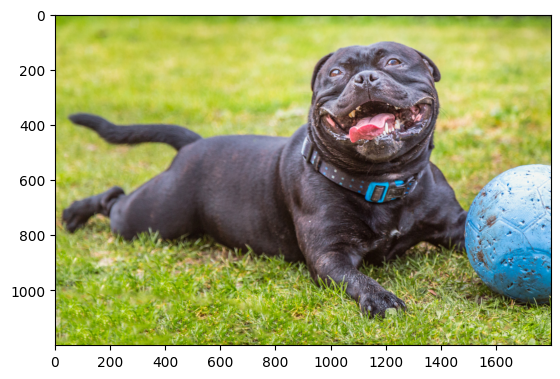

In [15]:
readable_prediction("../Data/doggy_door_images/happy_dog.jpg")

Original image shape:  (2592, 3456, 3)
Top results: brown_bear, American_black_bear, sloth_bear


torch.return_types.topk(
values=tensor([38.8241, 30.7904, 25.6888], grad_fn=<TopkBackward0>),
indices=tensor([294, 295, 297]))

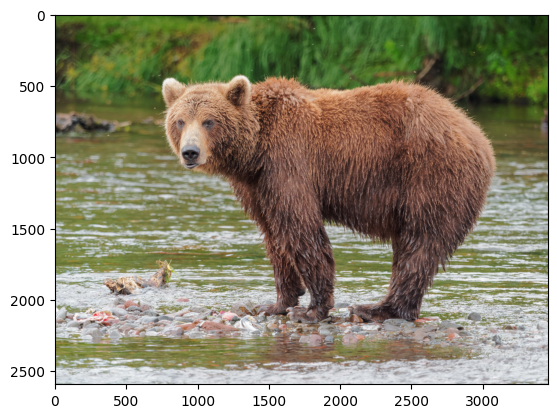

In [16]:
readable_prediction("../Data/doggy_door_images/brown_bear.jpg")

Original image shape:  (1200, 1800, 3)
Top results: tiger_cat, tabby, Persian_cat


torch.return_types.topk(
values=tensor([13.7197, 11.0977, 10.0628], grad_fn=<TopkBackward0>),
indices=tensor([282, 281, 283]))

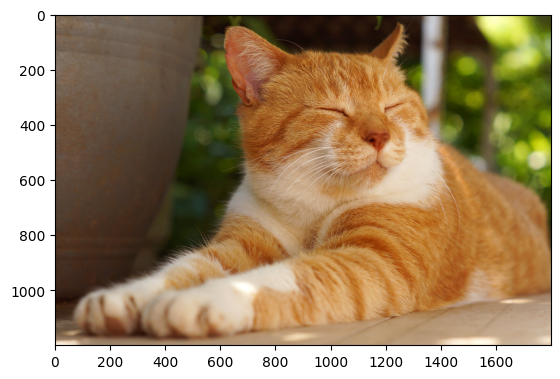

In [18]:
readable_prediction("../Data/doggy_door_images/sleepy_cat.jpg")

## 5a.6 Only Dogs

Now that we are making predictions with our model, we can use our categories to only let dogs in and out and keep cats inside. The dogs are categories 151 through 268 and cats are categories 281 through 285.

#### Exercise

We used this [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) function in the previous lesson. Do you remember which dimension we are pulling indexes from?

**Hint**: The first dimension is the batch dimension.

In [19]:
def doggy_door(image_path):
    show_image(image_path)
    image = load_and_process_image(image_path)
    idx = model(image).argmax(dim=1).item()
    print("Predicted index:", idx)
    if 151 <= idx <= 268:
        print("Doggy come on in!")
    elif 281 <= idx <= 285:
        print("Kitty stay inside!")
    else:
        print("You're not a dog! Stay outside!")

### Solution

Click on the `...` below to see the solution.

In [ ]:
# SOLUTION
import numpy as np

def doggy_door(image_path):
    show_image(image_path)
    image = load_and_process_image(image_path)
    idx = model(image).argmax(dim=1).item()
    print("Predicted index:", idx)
    if 151 <= idx <= 268:
        print("Doggy come on in!")
    elif 281 <= idx <= 285:
        print("Kitty stay inside!")
    else:
        print("You're not a dog! Stay outside!")

Original image shape:  (2592, 3456, 3)
Predicted index: 294
You're not a dog! Stay outside!


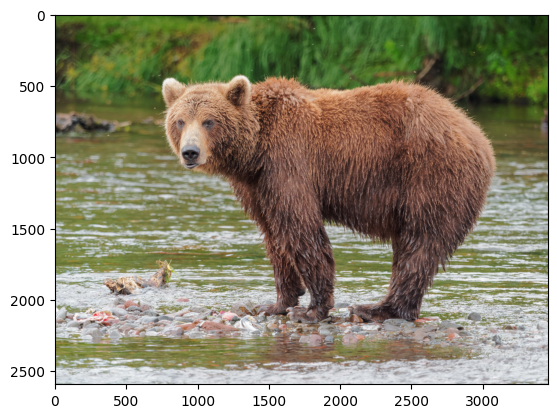

In [20]:
doggy_door("../Data/doggy_door_images/brown_bear.jpg")

Original image shape:  (1200, 1800, 3)
Predicted index: 179
Doggy come on in!


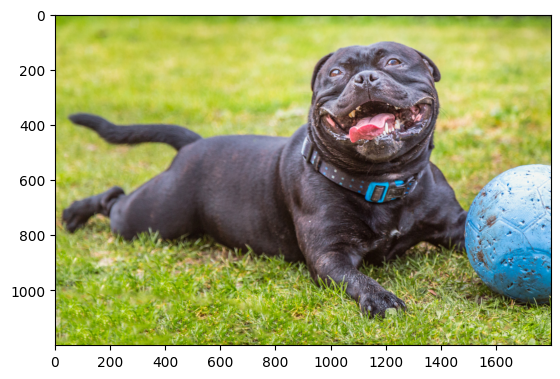

In [21]:
doggy_door("../Data/doggy_door_images/happy_dog.jpg")

Original image shape:  (1200, 1800, 3)
Predicted index: 282
Kitty stay inside!


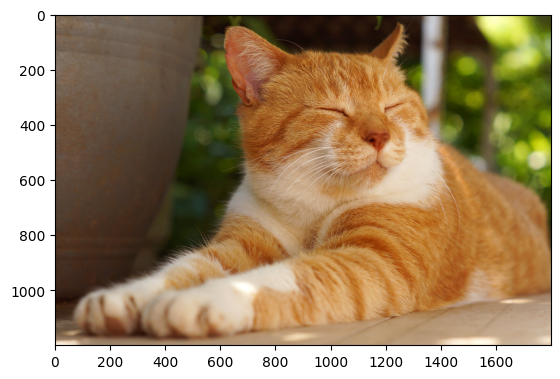

In [22]:
doggy_door("../Data/doggy_door_images/sleepy_cat.jpg")

## Summary

Great work! Using a powerful pre-trained model, we have created a functional doggy door in just a few lines of code. We hope you are excited to take advantage of deep learning without a lot of up-front work. The best part is, as the deep learning community moves forward, more models will become available for you to use on your own projects.

### Clear the Memory
Before moving on, please execute the following cell to clear up the GPU memory.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Next

Using pretrained models is incredibly powerful, but sometimes they are not a perfect fit for your data. In the next section you will learn about another powerful technique, *transfer learning*, which allows you to tailer pretrained models to make good predictions for your data.

Continue to the next section: [*Pretrained Models*](./05b_presidential_doggy_door.ipynb).

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>